In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

from tied_utils_decay2 import tied_abs_units_decay, prob_of_hitting_down_in_norm_units, decay_sigmoid, rho_E_minus_small_t_NORM_TIED_fn, CDF_E_minus_small_t_NORM_fn
from scipy.integrate import trapezoid
import pandas as pd

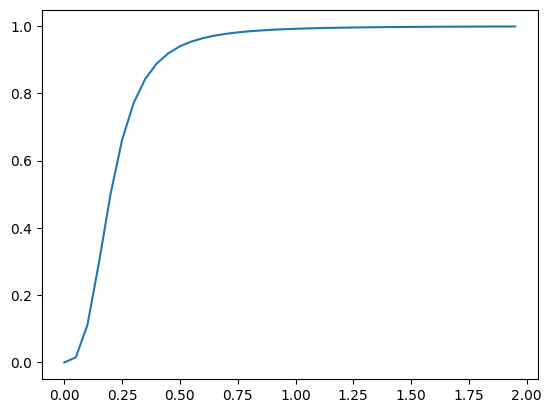

In [41]:
t_pts = np.arange(0, 2, 0.05)
n = 3
t0 = 0.2
sig = (t_pts**n) / (t0**n + t_pts**n)

plt.plot(t_pts, sig)

# params

In [2]:
# Stim params
# ILD_arr = [-6, -3, 0, 3, 6]
# ABL_arr = [20, 40, 60]

# ILD_arr = [1, -1, 2, -2, 4, -4, 8, -8, 16, -16]
ILD_arr = [2, -2, 8  ,-8]
ABL_arr = [20, 40, 60]

t_non_decision = 0.1
rate_lambda = 0.2
T_0 = 1 * 1e-3
theta_E = 20
dt = 1e-4

# gamma, mu_d, sigma_d, alpha
gamma = 0.0351
mu_d = 0.1
sigma_d = 0.05
alpha = 0.3

decay_params = {'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha}
# sim params
N_sim = int(50e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results_og = Parallel(n_jobs=-1)(delayed(tied_abs_units_decay)(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt, decay_params) for _ in range(N_sim))

In [4]:
# remove elements if 'choice' is none
sim_results = [x for x in sim_results_og if x['choice'] is not None]
print(f"Number of valid simulations: {len(sim_results)}")

nan_sim_results = [x for x in sim_results_og if x['choice'] is None]
print(f"Number of NaN simulations: {len(nan_sim_results)}")

Number of valid simulations: 50000
Number of NaN simulations: 0


(0.0, 2.0)

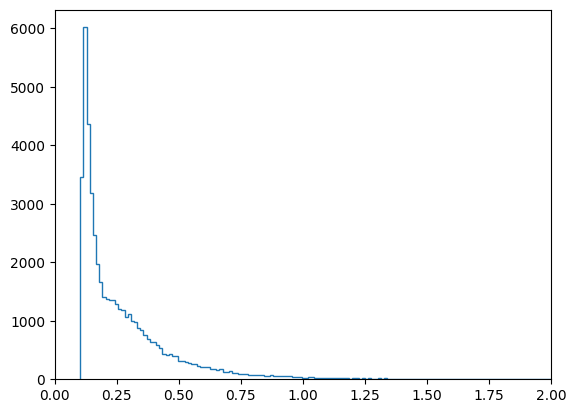

In [5]:
plt.hist([res['rt'] for res in sim_results], bins=250, histtype='step');
plt.xlim(0,2)

# Likelihood check

In [6]:
ABL = ABL_arr[0]
ILD = ILD_arr[0]
data_bins=np.arange(0, 2, 0.01)
data_t_pts = data_bins[:-1] + (data_bins[1] - data_bins[0])/2

theory_bins = np.arange(0, 3, 5e-4)
t_pts = theory_bins[:-1] + (theory_bins[1] - theory_bins[0])/2


likelihood_up = np.zeros(len(t_pts))
likelihood_down = np.zeros(len(t_pts))
omega = (2 / (T_0 * (theta_E**2))) * (10**( (rate_lambda * ABL) / 20))

for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)


Area of up hist: 0.7171608252786333
Area of up theory: 0.7151842774153871
Area of down hist: 0.2825982742090124
Area of down theory: 0.28469312844580197


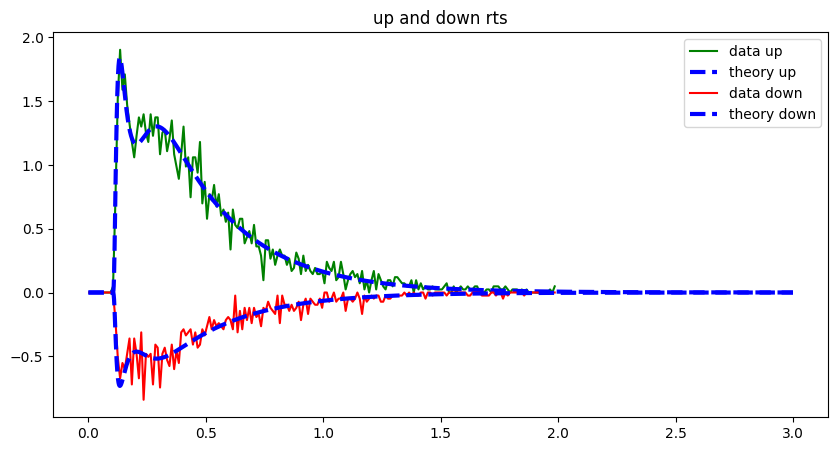

In [7]:
up_rts = [res['rt'] for res in sim_results if res['choice'] == 1 and res['ABL'] == ABL and res['ILD'] == ILD]
down_rts = [res['rt'] for res in sim_results if res['choice'] == -1 and res['ABL'] == ABL and res['ILD'] == ILD]

up_rt_hist, _ = np.histogram(up_rts, bins=data_bins, density=True)
down_rt_hist, _ = np.histogram(down_rts, bins=data_bins, density=True)

N_total = len([res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD])
N_up = len(up_rts)
N_down = len(down_rts)

plt.figure(figsize=(10, 5))
plt.plot(data_t_pts, up_rt_hist*(N_up/N_total), label='data up', color='g')
plt.plot(t_pts, likelihood_up, label='theory up', ls='--', color='b', lw=3)

plt.plot(data_t_pts, -down_rt_hist*(N_down/N_total), label='data down',  color='r')
plt.plot(t_pts, -likelihood_down, label='theory down', ls='--', color='b', lw=3)

plt.legend()
plt.title('up and down rts')
print(f'Area of up hist: {trapezoid(up_rt_hist, data_t_pts) * N_up/N_total}')
print(f'Area of up theory: {trapezoid(likelihood_up, t_pts)}')

print(f'Area of down hist: {trapezoid(down_rt_hist, data_t_pts) * N_down/N_total}')
print(f'Area of down theory: {trapezoid(likelihood_down, t_pts)}')

In [8]:
theory_all = np.zeros_like(t_pts)
for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    theory_all[idx] = likelihood_up + likelihood_down

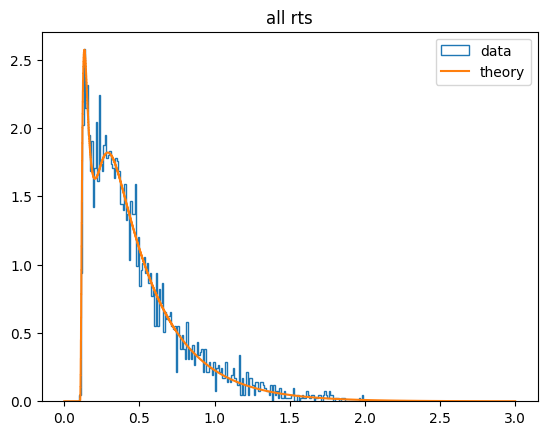

In [9]:
all_rts = [res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD]
plt.hist(all_rts, bins=data_bins, histtype='step', density=True, label='data');

plt.step(t_pts, theory_all, label='theory')
plt.legend()
plt.title('all rts');

# loglike fn

In [10]:
T_trunc = 0.2
K_max = 10

In [11]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    if rt < T_trunc:
        prob = 0
    else:
        if choice == 1:
            prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision)
        elif choice == -1:
            prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision)

        trunc_factor = CDF_E_minus_small_t_NORM_fn(T_trunc, ABL, ILD, rate_lambda, T_0, theta_E, 0, 1, K_max) + \
                         CDF_E_minus_small_t_NORM_fn(T_trunc, ABL, ILD, rate_lambda, T_0, theta_E, 0, -1, K_max)
        
        prob /= trunc_factor

    if prob <= 0:
        return np.log(1e-50)
    else:
        return np.log(prob)

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision, \
                                                               ) for res in sim_results)
    loglike = np.sum(all_loglike)

    return loglike

# Bounds

In [12]:
t_non_decision_bounds = [0*(1e-3), 150*(1e-3)]
rate_lambda_bounds = [0, 0.3]
T_0_bounds = [0.1*(1e-3), 1.5*(1e-3)]
theta_E_bounds = [5, 60]
# gamma_bounds = [0.01, 0.1]
# mu_d_bounds = [0.05, 0.2]
# sigma_d_bounds = [0.01, 0.1]
# alpha_bounds = [0.1, 0.5]

t_non_decision_plausible_bounds = [80*(1e-3), 120*(1e-3)]
rate_lambda_plausible_bounds = [0.15, 0.25]
T_0_plausible_bounds = [0.7*(1e-3), 1.2*(1e-3)]
theta_E_plausible_bounds = [15, 35]
# gamma_plausible_bounds = [0.02, 0.05]
# mu_d_plausible_bounds = [0.07, 0.15]
# sigma_d_plausible_bounds = [0.03, 0.07]
# alpha_plausible_bounds = [0.2, 0.4]


# True params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# Prior

In [13]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
   
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

# prior + likelihood

In [14]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

# run vbmc

In [15]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10    -2736930.52     32987.13          inf        2        inf     start warm-up
     1         15    -2719327.56     38894.17     29512.43        2        inf     
     2         20    -2717373.62      9325.78     18513.05        2   3.46e+05     
     3         25    -2649804.69     58658.69   8803870.93        2   1.47e+08     
     4         30    -2666274.12       669.49     10599.98        2   2.34e+05     
     5         35    -2650497.49      2698.71     81935.87        2   1.43e+06     
     6         40    -2646186.96      8969.16     70672.50        2   1.22e+06     
     7         45    -2646632.69      1383.5

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    21        115    -2539283.50    121283.92      3583.86        2   6.08e+05     
    22        120    -2564845.79     86628.34     21352.31        2    7.3e+05     
    23        125    -2600545.34     58650.93       304.48        2    3.2e+05     trim data
    24        130    -2644815.82      1252.55 1305071707.15        2   2.18e+10     
    25        135    -2645967.74        11.12 6318685432944.55        2   1.05e+14     
    26        140    -2645908.29        87.04       317.78        2   5.78e+03     
    27        145    -2645968.11         8.96      1168.68        2   1.97e+04     
    28        150    -2645860.23       160.60      1727.94        2   2.97e+04     
    29        155    -2645714.86       290.07         2.20        2   1.49e+03     
    30        160    -2645968.74         3.88     20141.37        2   3.37e+05     
    31        165    -2645969.21         0.29        21.18        2        356     
    32        170    -2645960.12        23.80      5326.68    

# corner

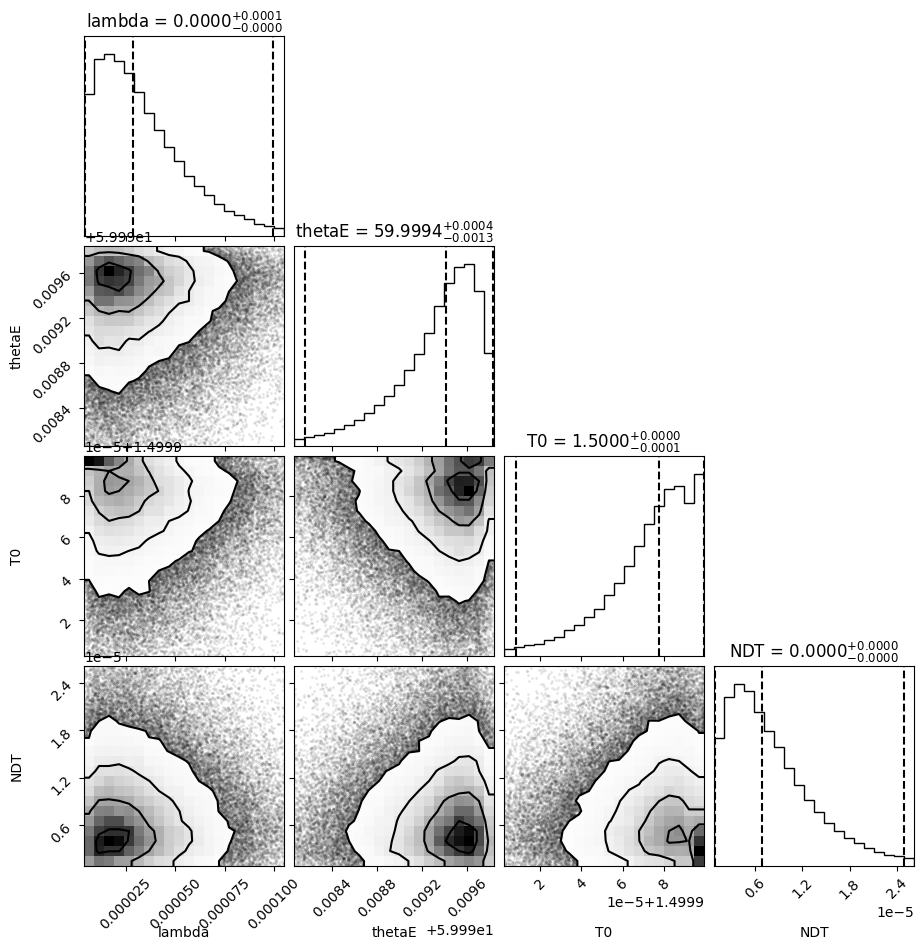

In [16]:
vp_samples = vp.sample(int(1e5))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]*1e3
t_non_decision_samp = vp_samples[:, 3]
# sigma_d_samp = vp_samples[:, 6]
# alpha_samp = vp_samples[:, 7]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']
true_arr = [rate_lambda, theta_E, T_0*1e3, t_non_decision]
# corner_span = [(0.07, 0.085), (46, 55), (0.16*(1e-3), 0.25*(1e-3)), (77*(1e-3), 79*(1e-3))]
corner_span = [np.percentile(combined_samples[:, i], [2, 98]) for i in range(combined_samples.shape[1])]

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr, title_fmt=".4f",range=corner_span);
 

# Diagnostics

In [19]:
# rate_lambda_samp = vp_samples[:, 0]
# theta_E_samp = vp_samples[:, 1]
# T_0_samp = vp_samples[:, 2]*1e3
# t_non_decision_samp = vp_samples[:, 3]
# gamma_samp = vp_samples[:, 4]
# mu_d_samp = vp_samples[:, 5]
# sigma_d_samp = vp_samples[:, 6]
# alpha_samp = vp_samples[:, 7]

rate_lambda_mean = np.mean(rate_lambda_samp)
theta_E_mean = np.mean(theta_E_samp)
T_0_mean = np.mean(T_0_samp)
t_non_decision_mean = np.mean(t_non_decision_samp)



In [ ]:
T_0_mean = T_0_mean * 1e-3
T_0_mean

In [ ]:
print(f'rate_lambda: {rate_lambda_mean}')
print(f'theta_E: {theta_E_mean}')
print(f'T_0: {T_0_mean}')
print(f't_non_decision: {t_non_decision_mean}')

In [21]:
def tied_abs_units_non_decay(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt, max_time=100):
    ILD = np.random.choice(ILD_arr)
    ABL = np.random.choice(ABL_arr)


    max_steps = int(np.ceil(max_time / dt))
    t = np.arange(0, max_steps * dt, dt)
    dB = np.sqrt(dt)
    chi = 17.37

    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))
    
    # decay = (1/c)*np.exp(-t / c) + c1
    decay = 1

    mu = common * (rate_lambda * ILD / chi) * decay
    sigma = np.sqrt(common * decay)
    
    noise = np.random.normal(0, dB, size=max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= theta_E) | (DV <= -theta_E))[0]
    if crossing_indices.size > 0:
        t_cross = t[crossing_indices[0]]
        choice = +1 if DV[crossing_indices[0]] > theta_E else -1
        return {'choice': choice, 'rt': t_cross + t_non_decision, 'ILD': ILD,  'ABL': ABL}
    else:
        return {'choice': None, 'rt': np.nan, 'DV': DV}


In [22]:
fit_sim_results = Parallel(n_jobs=-1)(delayed(tied_abs_units_non_decay)(ILD_arr, ABL_arr, rate_lambda_mean, theta_E_mean, T_0_mean, t_non_decision_mean, dt) for _ in range(N_sim))


In [23]:
from diagnostics_class import Diagnostics

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df.head()

In [ ]:
fit_results_df = pd.DataFrame(fit_sim_results)
fit_results_df.head()

In [26]:
# add correct column = 1if ILD* choice > 1,  else 0
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice'] > 0).astype(int)

In [27]:
fit_results_df['correct'] = (fit_results_df['ILD'] * fit_results_df['choice'] > 0).astype(int)

In [28]:
sim_results_df['t_stim'] = 0
fit_results_df['t_stim'] = 0

In [29]:
sim_results_diag = Diagnostics(sim_results_df)
fit_results_diag = Diagnostics(fit_results_df)

In [30]:
import itertools

# Define your standard colors in a list.
std_colors = ['r', 'b', 'g', 'm', 'k']

# Cycle through the colors if there are more ILDs than colors.
color_cycle = itertools.cycle(std_colors)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# %% PRELIMINARIES: Compute unique values and dynamic color mappings

ABL_arr = np.sort(sim_results_df['ABL'].unique())
ILD_arr = np.sort(sim_results_df['ILD'].unique())
# Only consider positive ILDs for the individual RTD plots:
pos_ILD = ILD_arr[ILD_arr > 0]

# Use a colormap that avoids bright yellow for ILD plots.
# (Change 'cividis' to another name if you prefer a different palette.)
cmap_ild = plt.get_cmap('tab10', len(pos_ILD))
ILD_color_mapping = {ild: next(color_cycle) for ild in pos_ILD}



# For ABL plots (e.g., in the psycho and chrono panels), we can still use a qualitative colormap:
cmap_abl = plt.get_cmap('tab10', len(ABL_arr))
ABL_color_mapping = {abl: cmap_abl(i) for i, abl in enumerate(ABL_arr)}

# %% SET UP FIGURE AND GRID-SPECS (unchanged except for later scatter calls)

# (Figure and GridSpec code remains the same …)

fig = plt.figure(figsize=(12*3, 19*3))
gs_main = GridSpec(nrows=3, ncols=1, height_ratios=[1, len(ABL_arr), 1], figure=fig)

# --- Top row: Three subplots (RTD, psycho, chrono)
gs_top = GridSpecFromSubplotSpec(
    nrows=1, ncols=3,
    subplot_spec=gs_main[0],
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3
)
ax_rtd    = fig.add_subplot(gs_top[0, 0])
ax_psy    = fig.add_subplot(gs_top[0, 1])
ax_chrono = fig.add_subplot(gs_top[0, 2])

# %% TOP ROW PLOTS

# (0) RTD summary plots remain unchanged.
bins = np.arange(0, 1, 0.01)
x_sim, y_sim = sim_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x_sim, y_sim, ls='--', color='b')
x_fit, y_fit = fit_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x_fit, y_fit, color='r', ls='--')
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)

# (1) Psycho plots – note the scatter size is now set to 250:
sim_psycho = sim_results_diag.plot_psycho()  # returns a dict with keys = ABL values
for ABL in sim_psycho.keys():
    ax_psy.scatter(ILD_arr, sim_psycho[ABL],
                   color=ABL_color_mapping[ABL],
                   s=250)
fit_psycho = fit_results_diag.plot_psycho()
for ABL in fit_psycho.keys():
    ax_psy.plot(ILD_arr, fit_psycho[ABL], alpha=0.9,
                color=ABL_color_mapping[ABL], ls='--')
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)

# (2) Chrono plots – the scatter call now also uses s=250:
all_ABL_chrono = np.sort(sim_results_df['ABL'].unique())
all_ILD_chrono = np.sort(sim_results_df['ILD'].unique())
all_ILD_chrono = all_ILD_chrono[all_ILD_chrono > 0] 
sim_chrono = {}
for ABL in all_ABL_chrono:
    per_ILD_rt = np.zeros_like(all_ILD_chrono, dtype=float)
    for idx, ILD in enumerate(all_ILD_chrono):
        filtered_df = sim_results_df[(sim_results_df['ABL'] == ABL) &
                                     (sim_results_df['ILD'].isin([ILD, -ILD]))]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace(
            [np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    sim_chrono[ABL] = per_ILD_rt

fit_chrono = {}
for ABL in all_ABL_chrono:
    per_ILD_rt = np.zeros_like(all_ILD_chrono, dtype=float)
    for idx, ILD in enumerate(all_ILD_chrono):
        filtered_df = fit_results_df[(fit_results_df['ABL'] == ABL) &
                                     (fit_results_df['ILD'].isin([ILD, -ILD]))]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace(
            [np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    fit_chrono[ABL] = per_ILD_rt

for ABL in sim_chrono.keys():
    ax_chrono.scatter(np.log(all_ILD_chrono), sim_chrono[ABL],
                      color=ABL_color_mapping[ABL],
                      s=250)
    ax_chrono.plot(np.log(all_ILD_chrono), fit_chrono[ABL],
                   color=ABL_color_mapping[ABL], ls='--')
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 0.4)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 0.6, 0.1))

# %% MIDDLE GRID: Individual RTD distributions per ABL and positive ILD

gs_mid = GridSpecFromSubplotSpec(
    nrows=len(ABL_arr), ncols=len(pos_ILD),
    subplot_spec=gs_main[1],
    hspace=0.1, wspace=0.3
)
bins_hist = np.arange(0, 1, 0.01)
t_pts = bins_hist[:-1] + 0.5*(bins_hist[1] - bins_hist[0])
for i, ABL in enumerate(ABL_arr):
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs_mid[i, j])
        # Simulation RTD histogram:
        sim_pd = sim_results_df[(sim_results_df['ABL'] == ABL) &
                                (sim_results_df['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']
        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins_hist)
        ax.step(t_pts, sim_rt_hist,
                color=ILD_color_mapping[ILD], label='sim')
        # Fit RTD histogram:
        fit_pd = fit_results_df[(fit_results_df['ABL'] == ABL) &
                                (fit_results_df['ILD'].isin([ILD, -ILD]))]
        fit_rt = fit_pd['rt'] - fit_pd['t_stim']
        fit_rt_hist, _ = np.histogram(fit_rt, density=True, bins=bins_hist)
        ax.step(t_pts, fit_rt_hist, color=ILD_color_mapping[ILD],
                label='fit', linestyle='--')
        if i == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
            ax.tick_params(axis='x', which='major', labelsize=20)
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(f'ABL = {ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        else:
            ax.set_yticks([])
        if i == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if j != 0:
            ax.spines['left'].set_visible(False)

# %% BOTTOM GRID: Tacho plots (one per ABL)

# Create a sub-GridSpec for the bottom row: one column per ABL.
n_ABL = len(ABL_arr)
gs_bottom = GridSpecFromSubplotSpec(
    nrows=1, ncols=n_ABL,
    subplot_spec=gs_main[2],
    wspace=0.2
)
# Instead of hardcoding three axes, create one per ABL.
for i, ABL in enumerate(ABL_arr):
    ax_tacho = fig.add_subplot(gs_bottom[0, i])
    
    # Define ILD groups for “hard” and “easy” trials.
    hard_ILD = np.array([1, -1, 2, -2, 4, -4])
    easy_ILD = np.array([8, -8, 16, -16])
    bins_tacho = np.arange(0, 0.6, 0.02)
    
    # sim - easy
    sim_pd_easy = sim_results_df[(sim_results_df['ABL'] == ABL) &
                                 (sim_results_df['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins_tacho)
    ax_tacho.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df[(sim_results_df['ABL'] == ABL) &
                                 (sim_results_df['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins_tacho)
    ax_tacho.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')
    
    # fit - easy
    fit_pd_easy = fit_results_df[(fit_results_df['ABL'] == ABL) &
                                 (fit_results_df['ILD'].isin(easy_ILD))]
    fit_pd_easy_diag = Diagnostics(fit_pd_easy)
    x, fit_easy_tacho = fit_pd_easy_diag.plot_tacho(bins_tacho)
    ax_tacho.plot(x, fit_easy_tacho, label='fit easy', color='g', linestyle='--')
    
    # fit - hard
    fit_pd_hard = fit_results_df[(fit_results_df['ABL'] == ABL) &
                                 (fit_results_df['ILD'].isin(hard_ILD))]
    fit_pd_hard_diag = Diagnostics(fit_pd_hard)
    x, fit_hard_tacho = fit_pd_hard_diag.plot_tacho(bins_tacho)
    ax_tacho.plot(x, fit_hard_tacho, label='fit hard', color='r', linestyle='--')
    
    ax_tacho.set_xlabel(f'RT(s), ABL = {ABL}', fontsize=25)
    if i == 0:
        ax_tacho.legend(fontsize=18)
        ax_tacho.set_ylabel('accuracy', fontsize=25)
        ax_tacho.set_yticks(np.arange(0.2, 1.2, 0.2))
    else:
        ax_tacho.spines['left'].set_visible(False)
        ax_tacho.set_yticks([])
    
    ax_tacho.spines['top'].set_visible(False)
    ax_tacho.spines['right'].set_visible(False)
    ax_tacho.spines['bottom'].set_visible(True)
    ax_tacho.tick_params(axis='both', which='major', labelsize=20)
    ax_tacho.tick_params(axis='x', which='major', labelsize=25)

plt.tight_layout()
plt.show()